# Prosta analiza danych
Autorka: Małgorzata Rucka

Importujemy potrzebne biblioteki i pobieramy potrzebne dane. Wczytujemy je mając na uwadze sposób, w jaki są zapisane.

In [1]:
import wget
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from zipfile import ZipFile


if not os.path.exists("AirQualityUCI.zip") :
    wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip')
    with ZipFile('AirQualityUCI.zip', 'r') as zipObj:
        zipObj.extractall()
data = pd.read_csv("AirQualityUCI.csv", parse_dates=['Date'], dayfirst = True, sep = ';', decimal = ',')
data = data.iloc[:9357]

Zbiór danych składa się z 9358 pomiarów właściwości powietrza. Pomiary dokonywane były co godzinę, we włoskim mieście narażonym na duże zanieczyszczenia powietrza. 

In [2]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2004-03-10,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,2004-03-10,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,2004-03-10,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,2004-03-10,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,2004-03-10,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


## Średnia dzienna wartość RH
Obliczamy średnią wartość RH w każdym dniu, a następnie wizualizujemy

In [23]:
cols = data[['Date', 'RH']].columns.difference(['Date'])
graph_data = data[['Date', 'RH']].set_index('Date').groupby(pd.Grouper(freq = 'd')).mean().dropna(how = 'all')
graph_data.head()

,RH
Date,
2004-03-10,54.900000
2004-03-11,64.075000
2004-03-12,51.095833
2004-03-13,51.533333
2004-03-14,48.850000


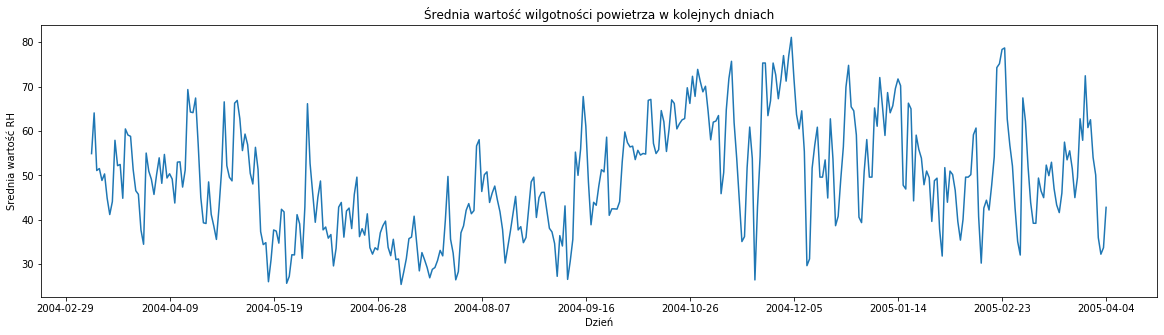

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(graph_data.index, graph_data['RH'])
ax.set_xlabel("Dzień")
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.set_ylabel('Srednia wartość RH')
ax.set_title("Średnia wartość wilgotności powietrza w kolejnych dniach")
plt.show()

## Wypełnianie pustych wartości medianą

Wartości puste w zbiorze danych są wypełnione wartością -200. Obliczmy medianę, a następnie podstawiamy w te miejsca.

In [5]:
median = data.loc[data['RH']>-200, 'RH'].median()
print('Mediana:',median)

Mediana: 49.6


Ponownie wizualizujemy dane, tym razem z przekształconymi pustymi wartościami

In [6]:
data['RH'] = data['RH'].apply(lambda x: median if x == -200 else x)
cols = graph_data.columns.difference(['Date'])
graph_data = data[['Date', 'RH']].set_index('Date').groupby(pd.Grouper(freq = 'd')).mean().dropna(how = 'all')

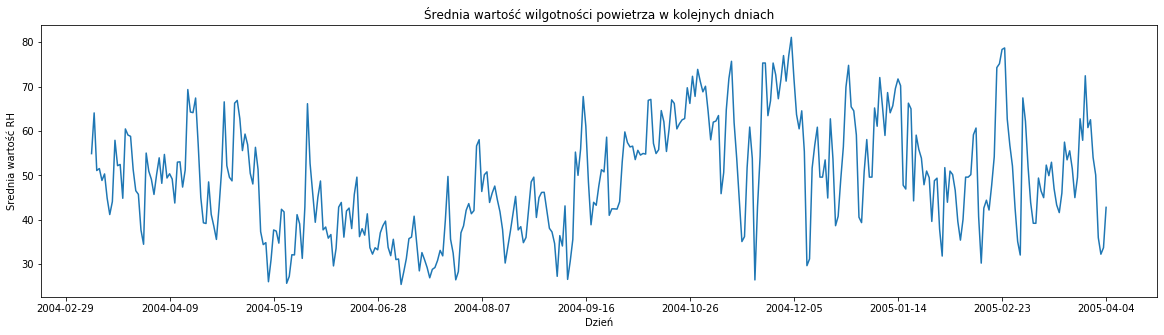

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(graph_data.index, graph_data['RH'])
ax.set_xlabel("Dzień")
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.set_ylabel('Srednia wartość RH')
ax.set_title("Średnia wartość wilgotności powietrza w kolejnych dniach")
plt.show()
fig.set_size_inches(20, 5)

## Odnalezienie oulierów

Rozpoczęto od wizualizacji danych i ich rozkładu. Co prawda boxplot nie ukazuje outlierów - bierze on jednak pod uwagę cały zbiór danych, a nie pojedyncze okresy.

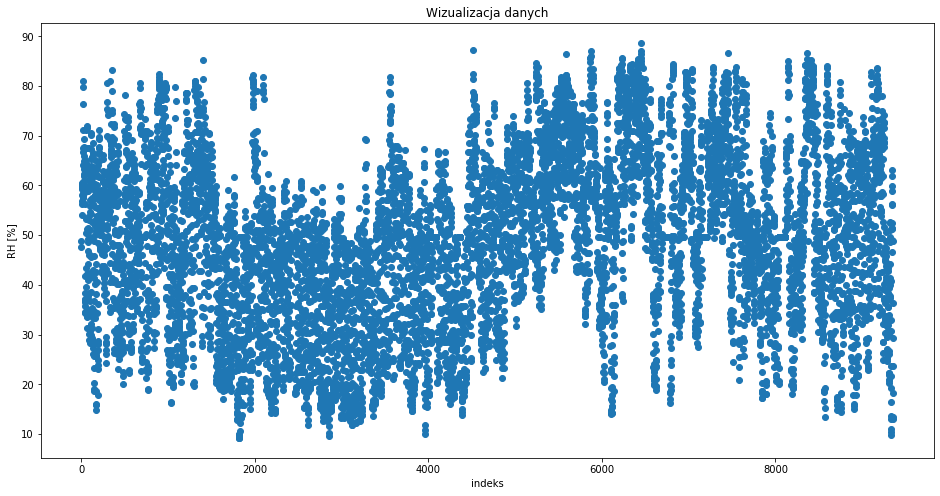

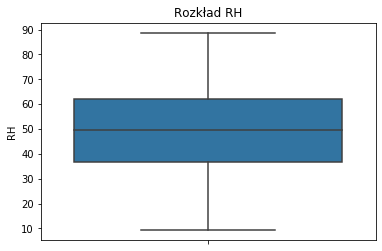

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y=data['RH'], x=data.index)
ax.set_title("Wizualizacja danych")
ax.set_ylabel('RH [%]')
ax.set_xlabel("indeks")
plt.show()
sns.boxplot(y=data['RH'])
plt.title('Rozkład RH')
plt.show()

Początkowo próbowano użyć algorytm uczenia nienadzorowanego DBSCAN oraz IsolationForest na całym zbiorze danych, jednak dawały one nieoptymalne rezultaty, które wyglądały jak ustawione progi.

In [9]:
clustering = (DBSCAN(eps = 0.5, min_samples = 50).fit_predict(np.array(data['RH']).reshape(-1, 1)))
data['outlier'] = clustering
data['outlier'] = data['outlier'].apply(lambda x: True if x == -1 else False) 

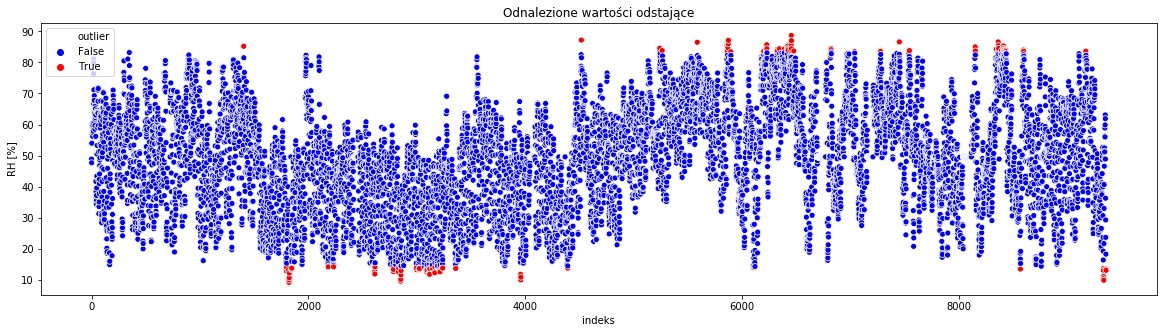

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.scatterplot(y = 'RH', x = data.index, data = data, hue = 'outlier', palette = ['blue','red'])
ax.set_title("Odnalezione wartości odstające")
ax.set_ylabel('RH [%]')
ax.set_xlabel("indeks")
plt.show()

Aby poprawić wyniki, ustawiono okno zawierające jeden miesiąc danych, i na nich szukano outlinerów. Metoda dała bardziej zadowalające rezulaty.

In [11]:
clustering = []
for i in range(13):
    clustering+=(list(DBSCAN(eps = 2, min_samples = 15).fit_predict(np.array(data['RH'][i*720:(i+1)*720]).reshape(-1, 1))))

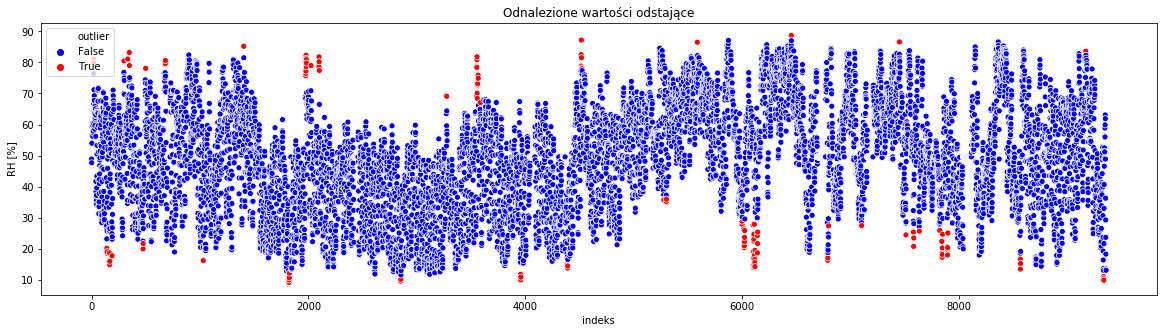

In [12]:
data['outlier'] = clustering[:9357]
data['outlier'] = data['outlier'].apply(lambda x: True if x == -1 else False) 
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.scatterplot(y = 'RH', x = data.index, data = data, hue = 'outlier', palette = ['blue','red'])
ax.set_title("Odnalezione wartości odstające")
ax.set_ylabel('RH [%]')
ax.set_xlabel("indeks")
plt.show()

In [13]:
preds = []
for i in range(13):
    clf = IsolationForest(contamination= float(.01))
    preds += list(clf.fit_predict(np.array(data['RH'][i*720:(i+1)*720]).reshape(-1, 1)))

In [14]:
data['outlierForest'] = preds
data['outlierForest'] = data['outlierForest'].apply(lambda x: True if x == -1 else False) 

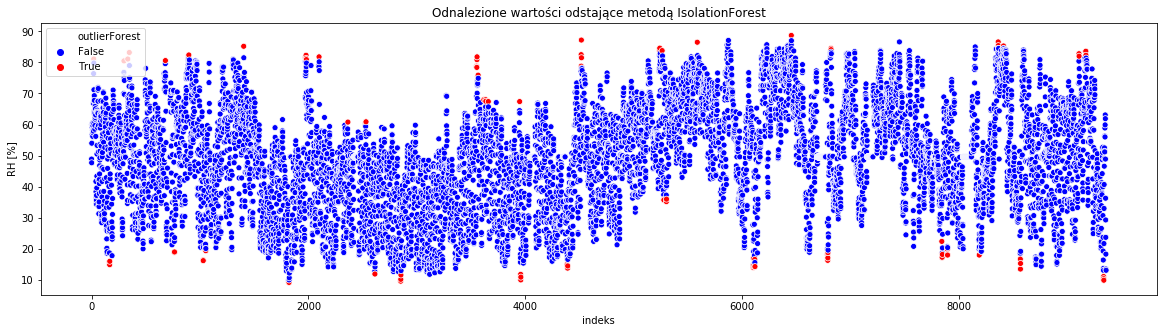

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.scatterplot(y = 'RH', x = data.index, data = data, hue = 'outlierForest', palette = ['blue','red'])
ax.set_title("Odnalezione wartości odstające metodą IsolationForest")
ax.set_ylabel('RH [%]')
ax.set_xlabel('indeks')
plt.show()

W moim przekonaniu DBSCAN poradził sobie lepiej w poszukiwaniu wartości odstających, udało się za jego pomocą odnaleźć zarówno pojedyncze punkty jak i skupiska.

## Analiza korelacji temperatury oraz wilgotności powietrza

Przygotowano dane na pomiarowe temperatury w ten sam sposób, co dane pomiarowe RH. Wyrysowano rozkład.

In [16]:
median = data.loc[data['T']> -200,'T'].median()
data['T'] = data['T'].apply(lambda x: median if x == -200 else x)

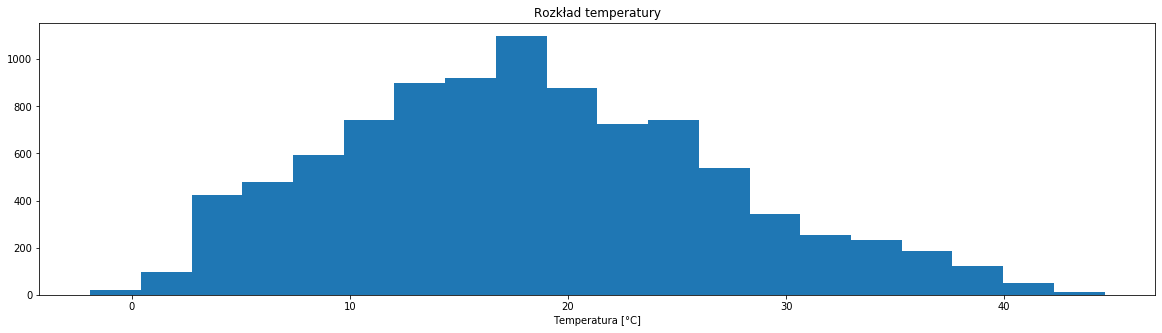

Różnica między średnią a medianą: 0.50


In [17]:
graph_data = data[['Date', 'T']]
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.hist(graph_data['T'],bins = 20)
ax.set_title("Rozkład temperatury")
ax.set_xlabel("Temperatura [°C]")
plt.show()
print('Różnica między średnią a medianą: {:.2f}'.format(data.loc[data['T']> -200,'T'].mean()-data.loc[data['T']> -200,'T'].median()))

Temperatura ma rozkład prawostronnie skośny.

Narysowano wykres relacji między wartością RH a temperaturą, z uwzględnieniem outlierów.

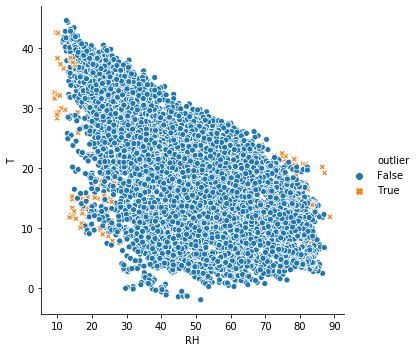

In [18]:
sns.relplot(x = 'RH', y = 'T', data = data, style = 'outlier', hue = 'outlier')
plt.show()

Narysowano macierz korelacji.

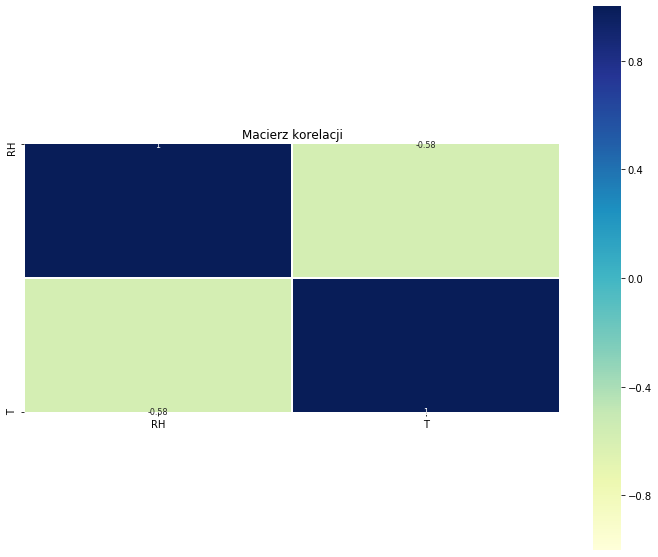

In [19]:
my_data_num_corr = data[['RH', 'T']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(my_data_num_corr[(my_data_num_corr >= 0.5) | (my_data_num_corr <= -0.5)], 
            cmap='YlGnBu', vmax=1, vmin=-1, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title("Macierz korelacji")
plt.show()

Cechy RH oraz T okazały się ujemnie skorelowane. Narysowano wykres średnich kroczących z 24 godzin, w celu zobrazowania ujemnej korelacji.

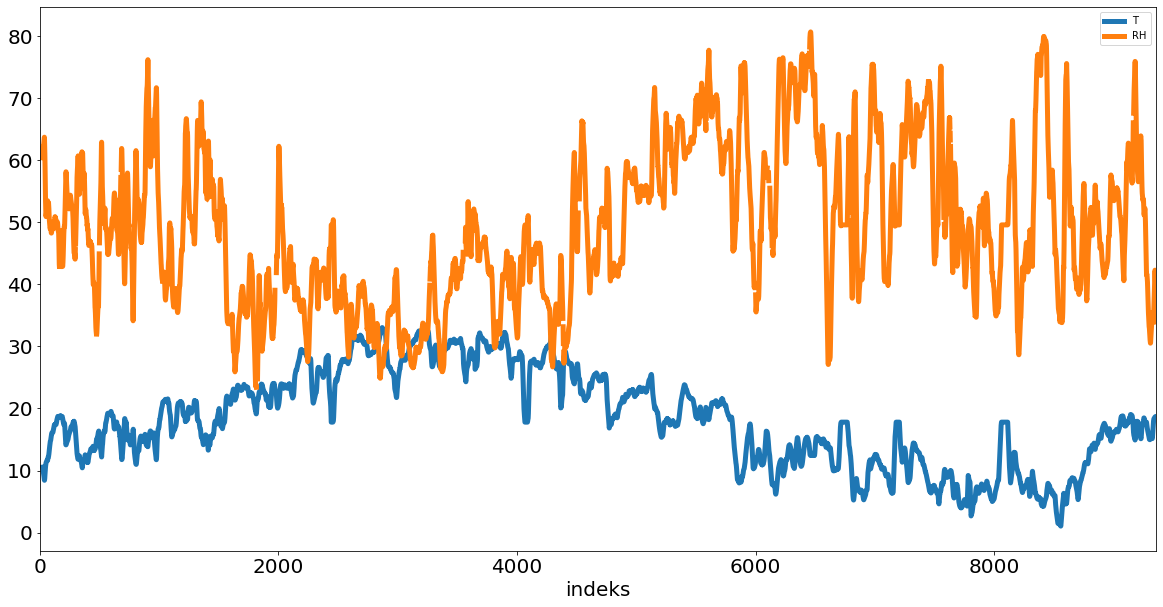

In [20]:
df_rm = pd.concat([data['T'].rolling(24).mean(), data.loc[data['outlier']==False, 'RH'].rolling(24).mean()], axis=1)
df_rm.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('indeks', fontsize=20);

Sprawdzono również korelację w momencie usunięcia trendu - ujemna korelacja jest jeszcze większa. Ujemna korelacja oznacza, że wraz ze wzrostem/spadkiem jednej zmiennej, druga zmienna zachowuje się odwrotnie i odpowiednio spada bądź rośnie. Wniosujemy, że wilgotność powietrza spada, gdy zwiększa się temperatura i odpowiednio rośnie, gdy temperatura maleje.

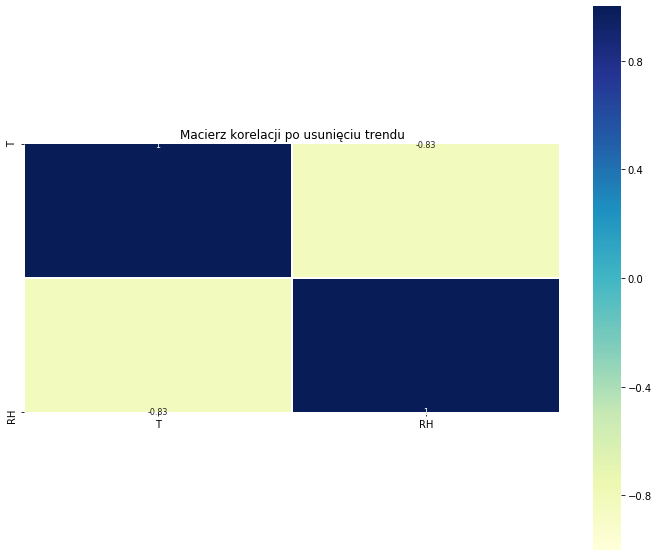

In [21]:
diff_corr = data[['T','RH']].diff().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(diff_corr, 
            cmap='YlGnBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title("Macierz korelacji po usunięciu trendu")
plt.show()